In [16]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import time

N=128      # Numero de cidades

rng = np.random.default_rng(seed=42)   # Define as posições aleatórias das cidades
x=rng.random(N)
y=rng.random(N)

# define o caminho que liga as cidades (inicialmente a sequencia como foi criada)
pathini = np.zeros(N,dtype=np.int16)
for i in range(N):
    pathini[i]=i
# Tempo FInal

In [17]:
#define a distancia entre duas cidades quaisquer
@jit(nopython=True)
def distances(N,x,y):
    
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))
            
    return dist

In [18]:
@jit(nopython=True)
def custo(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho
    
    return ener

In [19]:
@jit(nopython=True)
def newpath(N,path):
    
    # define uma nova caminhada
    
    newpath = np.zeros(N,dtype=np.int16)

    i=np.random.randint(N)   # escolhe uma posição aleatória da caminhada
    j=i
    while j==i:
        j=np.random.randint(N)  # escolhe outra posição 
    if i>j:                    # ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):        # inverte o sentido em que percorre o caminho entre os indices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin-k+ini]
        else:
            newpath[k] = path[k]

    return newpath,ini,fin



In [20]:
@jit(nopython=True)
def mcstep(N,beta,en,path,best_e,best_p,dist):
    # realiza um passo de Monte Carlo
    np1 = np.zeros(N,dtype=np.int16)
    
    np1,ini,fin = newpath(N,path) # propoe um novo caminho
    
    # determina a diferença de energia 
    esq = ini-1         # cidade anterior a inicial
    if esq < 0: esq=N-1      # condicao de contorno
    dir = fin +1        # cidade apos a final
    if dir > N-1: dir=0      # condicao de contorno
    de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]

    if de < 0:         # aplica o criterio de Metropolis
        en += de
        path = np1
        if en < best_e:  # guarda o melhor caminho gerado até o momento
            best_e = en
            best_p = path
    else:              # aplica o criterio de Metropolis
        if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1
            
    return en,path,best_e,best_p

In [21]:
@jit(nopython=True)
def execution(decrease_rate, begin_temperature, end_temperature, passos_de_monte_carlo, N, begin_path, x, y, n_restart):
    temperature = begin_temperature
    distance = distances(N, x, y)
    energy = custo(N, begin_path, distance)
    path = begin_path

    
    best_energy = energy
    best_path = begin_path
    
    count_restart_high_temp = n_restart
    count_restart_low_temp = n_restart
    count_do_again = n_restart
    while(temperature > end_temperature):

        for i in range(passos_de_monte_carlo):
            energy, path, best_energy, best_path = mcstep(N, 1 / temperature, energy, path, best_energy, best_path, distance)
        
        temperature *= decrease_rate
        

        # Os if's abaixo são responsáveis pelo restart ou seja responsável por aumentar a energia do sistema
        # Para que o mesmo aceite mudanças mais drasticas
        if count_restart_high_temp != 0 and temperature < begin_temperature * 0.5:
            temperature = begin_temperature * 1
            count_restart_high_temp -= 1 

        if count_restart_high_temp == 0 and count_restart_low_temp != 0 and temperature < begin_temperature * 0.01:
            temperature = begin_temperature * 0.4
            count_restart_low_temp -= 1 

        if temperature > end_temperature and count_do_again:
            temperature = begin_temperature
            count_do_again -= 1
            count_restart_high_temp = n_restart
            count_restart_low_temp = n_restart

        

    return best_path, best_energy

In [22]:
rng = np.random.default_rng(seed=42)

# Algoritmo para a Competição

## Inicia o Tempo

In [23]:
start_time = time.time()

## Abre o arquivo com as posições

In [24]:
file = open('arquivo_de_entrada/prof_example.dat')

location = []

for line in file:
    x, y = line.split(" ")
    x = float(x)
    y = float(y)
    location.append([x, y])

location = np.asarray(location)

x = location[:, 0]
y = location[:, 1]
N = x.size

pathini = np.zeros(N,dtype=np.int16)
for i in range(N):
    pathini[i]=i

## Executa o Algoritmo

A menor distancia encontrada foi: 8.802018444053829


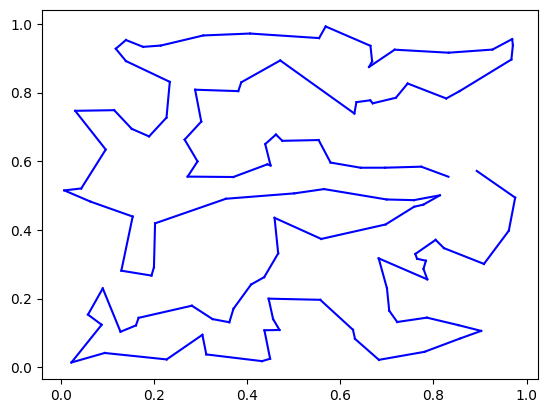

In [25]:
caminho, distacia = execution(0.99, 10, 0.0001, 250, N,pathini, x, y, n_restart=1)

print(f"A menor distancia encontrada foi: {distacia}")

for cidade in range (len(caminho) - 1):
    plt.plot([x[caminho[cidade]], x[caminho[cidade+1]]],[y[caminho[cidade]], y[caminho[cidade+1]]], 'b')

## Termina a função

In [26]:

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.2725844383239746 seconds ---


# A atividade está em elaboração